In [1]:
import pandas as pd

sequence_path_path = '/home/ec2-user/cytoself-data/sequences.csv'
sequences = pd.read_csv(sequence_path_path, index_col=0)

In [2]:
import pandas as pd

labels_path = '/home/ec2-user/cytoself-data/labels.csv'
labels = pd.read_csv(labels_path, index_col=0)
labels = labels.drop_duplicates('ensg')

/tmp/ipykernel_8512/445350896.py:4: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  labels = pd.read_csv(labels_path, index_col=0)


In [3]:
labels

,index,ensg,name,loc_grade1,loc_grade2,loc_grade3,protein_id,FOV_id,split_protein,split_images,label,Peptide,Protein stable ID,seq_embedding_index,truncation,localization,complex,complex_fig,split_images_fov
0,0,ENSG00000075624,ACTB,membrane;cytoskeleton,cytoplasmic,NaN,2,27979,train,train,0,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,ENSP00000494750,0,375,other,Pre-initiation complex (PIC),NaN,train
1641,1641,ENSG00000100591,AHSA1,nucleoplasm;cytoplasmic,NaN,NaN,3,6066,train,test,1,MAKWGEGDPRWIVEERADATNVNNWHWTERDASNWSTDKLKTLFLA...,ENSP00000216479,1,338,other,NaN,NaN,train
2947,2947,ENSG00000156735,BAG4,nucleoplasm,nucleolus_fc_dfc,NaN,7,27628,train,train,2,MSALRRSGYGPSDGPSYGRYYGPGGGDVPVHPPPPLYPLRPEPPQP...,ENSP00000287322,2,457,other,NaN,NaN,train
3961,3961,ENSG00000229524,BAG6,cytoplasmic;nucleoplasm,NaN,NaN,9,6185,train,train,3,MEPNDSTSTAVEEPDSLEVLVKTLDSQTRTFIVGAQMNVKEFKEHI...,ENSP00000397894,3,1024,other,NaN,NaN,train
4980,4980,ENSG00000105401,CDC37,cytoplasmic,nucleoplasm,NaN,10,6206,train,train,4,MVDYSVWDHIEVSDDEDETHPNIDTASLFRWRHQARVERMEQFQKE...,ENSP00000222005,4,378,other,NaN,NaN,val
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130172,66097,ENSG00000174749,C4orf32,er,NaN,NaN,2014,38613,train,train,1045,MCSAGELLRGGDGGERDEDGDALAEREAAGTGWDPGASPRRRGQRP...,ENSP00000310182,1306,132,ER,NaN,NaN,train
1131396,67321,ENSG00000138439,FAM117B,centrosome;nucleoplasm;cytoplasmic,NaN,NaN,2023,38853,train,train,1046,MSQRVRRNGSPTPAGSLGGGAVATAGGPGSRLQPMRATVPFQLKQQ...,ENSP00000376071,1307,589,other,NaN,NaN,test
1132045,67970,ENSG00000116001,TIA1,nucleoplasm;cytoplasmic,NaN,NaN,2025,38274,train,train,1047,MEDEMPKTLYVGNLSRDVTEALILQLFSQIGPCKNCKMIMDTAGND...,ENSP00000401371,1308,386,other,NaN,NaN,train
1132825,68750,ENSG00000108588,CCDC47,er,NaN,NaN,2038,38457,test,train,1310,MKAFHTFCVVLLVFGSVSEAKFDDFEDEEDIVEYDDNDFAEFEDVM...,ENSP00000225726,1309,483,other,NaN,NaN,test


In [4]:
import numpy as np

def get_X_y(labels, embeddings, split):
    labels_split = labels[np.logical_and(labels['split_protein'] == split,  labels['localization'] != 'other')]
    seq = labels_split['seq_embedding_index'].values
    loc = labels_split['localization'].values
    seq_length = labels_split['truncation'].values

    if isinstance(embeddings, np.ndarray):
        X = embeddings[seq]
    else:
        X = embeddings.get_orthogonal_selection(seq)
    
    if X.ndim == 3:
        X = X[:, 1:].sum(axis=1) / seq_length[:, None]
    return X, loc

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd


def fit_and_predict_localization(labels, embeddings, embeddings_2 = None):
    print('Loading')
    X_train, y_train = get_X_y(labels, embeddings, 'train')
    X_test, y_test = get_X_y(labels, embeddings, 'val')

    if embeddings_2 is not None:
        X_train_2, _ = get_X_y(labels, embeddings_2, 'train')
        X_test_2, _ = get_X_y(labels, embeddings_2, 'val')
        X_train = np.concatenate([X_train, X_train_2], axis=1)       
        X_test = np.concatenate([X_test, X_test_2], axis=1)

    print(f'Fitting {X_train.shape}')
    clf = LogisticRegression(random_state=0, penalty='l2', C=1).fit(X_train, y_train)
    y_predict = clf.predict(X_test)

    class_labels = np.unique(y_test)

    acc = accuracy_score(y_test, y_predict)
    print(f'Accuracy {acc} \n')

    cm = confusion_matrix(y_test, y_predict, labels=class_labels)
    cm_norm = cm / cm.sum(axis=1)[:, None]
    cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)

    return clf, cm_df


## ESM embeddings

In [26]:
import zarr

# esm_embeddings_path = '/home/ec2-user/cytoself-data/esm2_t33_650M_UR50D_32.zarr'
esm_embeddings_path = '/home/ec2-user/cytoself-data/ESM_sequence_embeddings_full_lora2.zarr'
embeddings = zarr.open(esm_embeddings_path)

In [27]:
clf, cm_df = fit_and_predict_localization(labels, embeddings) # 57.7 (33) vs 64.4 (32) vs 68.8 (lora 10k) vs 95.5 (lora 1k) !!!!

Loading
Fitting (398, 1280)
Accuracy 0.9555555555555556 



/opt/conda/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


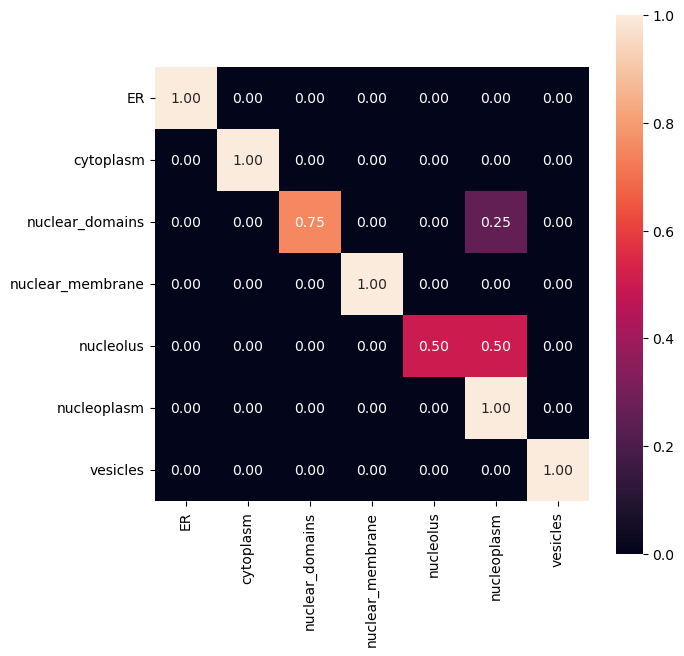

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");

## 3B ESM

In [13]:
import zarr

esm_embeddings_path = '/home/ec2-user/cytoself-data/esm2_t36_3B_UR50D_35.zarr'
embeddings = zarr.open(esm_embeddings_path)

In [14]:
clf, cm_df = fit_and_predict_localization(labels, embeddings) ## 68.88 (36) vs 71.11 (35) vs 71.11 (34)

Loading
Fitting (398, 2560)
Accuracy 0.7111111111111111 



/opt/conda/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


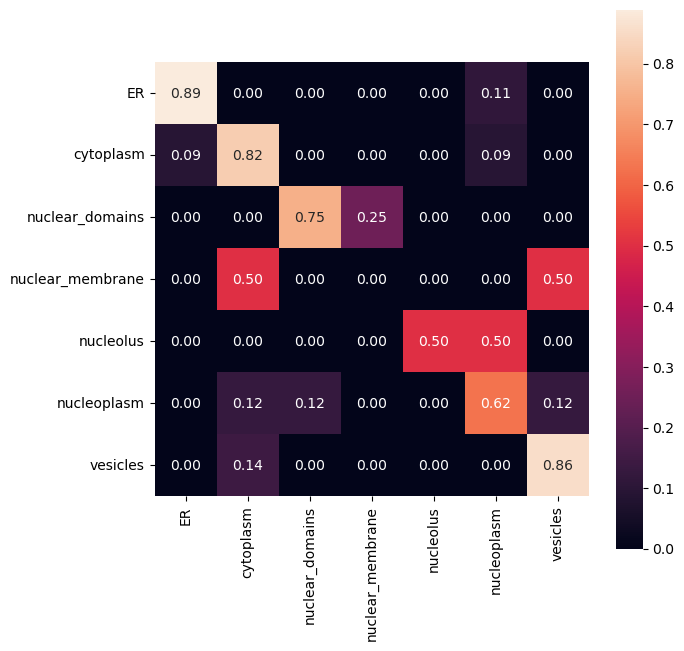

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");

## Random

In [174]:
embeddings = np.random.rand(1311, 256)

clf, cm_df = fit_and_predict_localization(labels, embeddings)

Loading
Fitting (398, 256)
Accuracy 0.13333333333333333 



/opt/conda/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


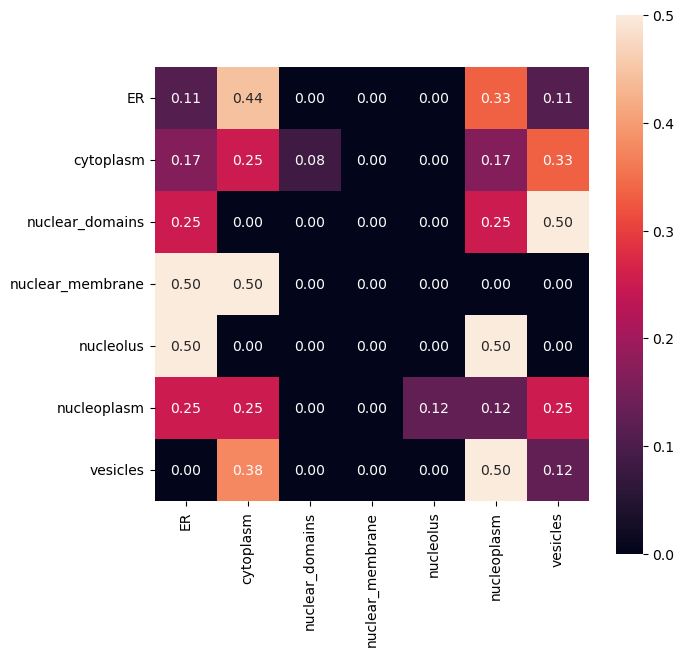

In [175]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");

## Geneformer

In [171]:
geneformer_embeddings_path = '/home/ec2-user/cytoself-data/geneformer_embeds.npy'
embeddings = np.load(geneformer_embeddings_path)

In [172]:
clf, cm_df = fit_and_predict_localization(labels, embeddings)

Loading
Fitting (398, 256)
Accuracy 0.4444444444444444 



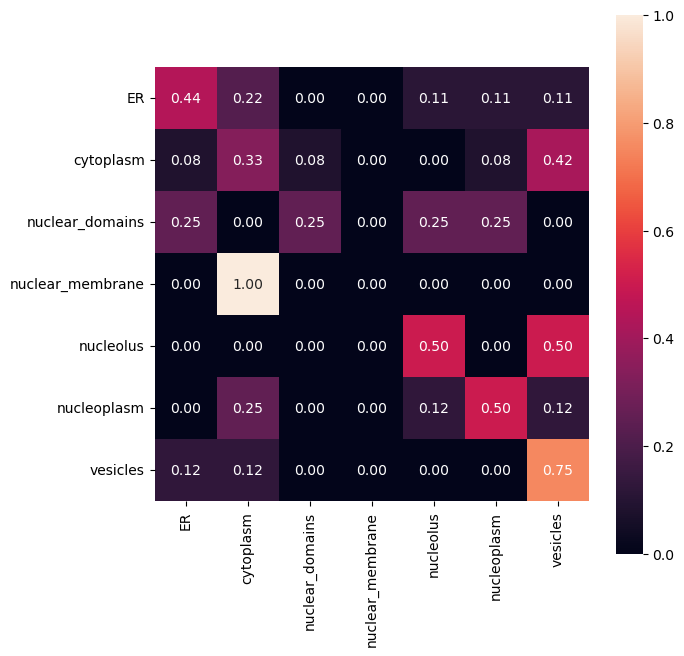

In [173]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");

## Geneformer + ESM

In [176]:
# esm_embeddings_path = '/home/ec2-user/cytoself-data/esm2_t33_650M_UR50D.zarr'
# embeddings = zarr.open(esm_embeddings_path)

esm_embeddings_path = '/home/ec2-user/cytoself-data/esm2_t36_3B_UR50D.zarr'
embeddings = zarr.open(esm_embeddings_path)

geneformer_embeddings_path = '/home/ec2-user/cytoself-data/geneformer_embeds.npy'
embeddings_2 = np.load(geneformer_embeddings_path)

In [177]:
clf, cm_df = fit_and_predict_localization(labels, embeddings, embeddings_2)

Loading
Fitting (398, 2816)
Accuracy 0.6222222222222222 



/opt/conda/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


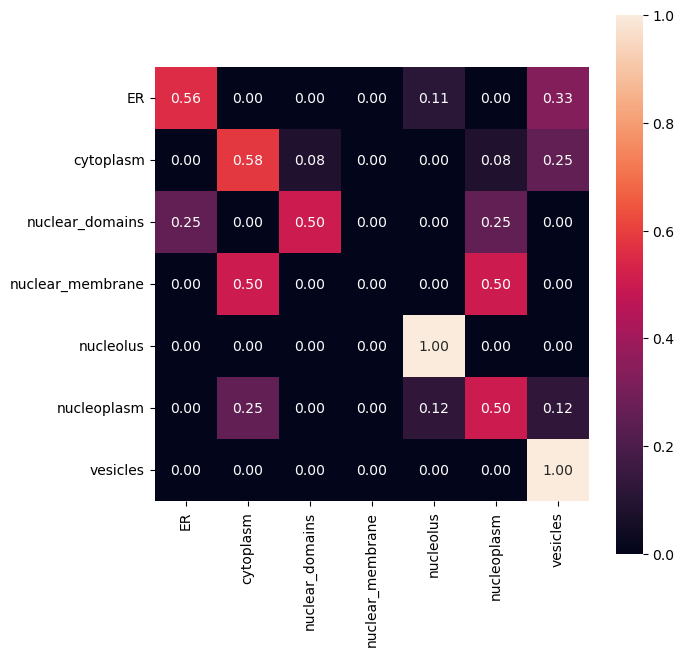

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");

## Scratch

In [135]:
X_train, y_train = get_X_y(labels, embeddings, 'train')
X_test, y_test = get_X_y(labels, embeddings, 'val')

In [152]:
print('Fitting')
clf = LogisticRegression(random_state=0, penalty='l2', C=1.0).fit(X_train, y_train)
y_predict = clf.predict(X_test)

class_labels = np.unique(y_test)

acc = accuracy_score(y_test, y_predict)
print(f'Accuracy {acc} \n')

Fitting
Accuracy 0.6888888888888889 



/opt/conda/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
